# Data Augmentation Practice

### Read in Sample Images

In [1]:
# Imports
import torch
import numpy as np
from PIL import Image
from torchvision import transforms

# Load Image
sample_img_png = Image.open("Inputs/mr_marmot_32x32.jpg")
sample_img_png_2 = Image.open("Inputs/mr_chipmunk_32x32.jpg")

# This Image is 32x32, But Might Need to Add Resize Code Here

# Convert Image to Tensor for MixUp and CutMix
### Define Function to Convert Image to Tensor
convert_img_to_tensor = transforms.Compose([transforms.ToTensor()])

### Call Function, Output of a 32x32 is (3, 32, 32).
sample_img_tensor = convert_img_to_tensor(sample_img_png)
sample_img_tensor_2 = convert_img_to_tensor(sample_img_png_2)
batch_images = torch.stack([sample_img_tensor, sample_img_tensor_2]) 

# Create a Batch of Images
batch_images = torch.stack([sample_img_tensor, sample_img_tensor_2]) 

# Reduce Saturation using Min-Max Normalization, Normalizing to [0, 1]
min_val = torch.min(batch_images)
max_val = torch.max(batch_images)
batch_images = (batch_images - min_val) / (max_val - min_val + 1e-7)  # Adding epsilon to prevent division by zero

# Define Labels
labels = torch.tensor([0, 1])

### Implementing CutMix

Cut a portion of one image and paste it onto another.

In [2]:
"""
Create Random Bounding Box
"""
def rand_bbox(size, mixup_lambda):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - mixup_lambda)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [3]:
"""
Create CutMix Function
    x = Tensor Inputs
    y = Labels
    Higher Alpha = More Mixing
"""
def apply_cutmix(x, y, alpha):
    if alpha > 0:
        # Sample from Beta distribution to get random shape parameters.
        mixup_lambda = np.random.beta(alpha, alpha)
    else:
        # Don't Mix.
        mixup_lambda = 1 
        
    # Note that 4D Tensor is Typically x.size(batch_size, channels, height, width).
    batch_size = x.size(0)
    
    # Randomly Shuffles Index Matches using Built-in Torch Function
    index = torch.randperm(batch_size)  
    
    # Generate the Bounding Box
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), mixup_lambda)
    
    # Cut and Paste
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    
    # Labels for Both Original and Mixed Data
    y_orig, y_mixed = y, y[index]

    # Return Images, Labels, and Lambda
    return x, y_orig, y_mixed, mixup_lambda

### Output CutMix Example Result

In [4]:
# Call Apply Cutmix
mixed_img_tensor, y_orig, y_mixed, mixup_lambda = apply_cutmix(batch_images, labels, alpha=0.6)

# Convert Returned Tensor to Image
mixed_img_single = mixed_img_tensor[0]
convert_tensor_to_img = transforms.ToPILImage()
mixed_img = convert_tensor_to_img(mixed_img_single)

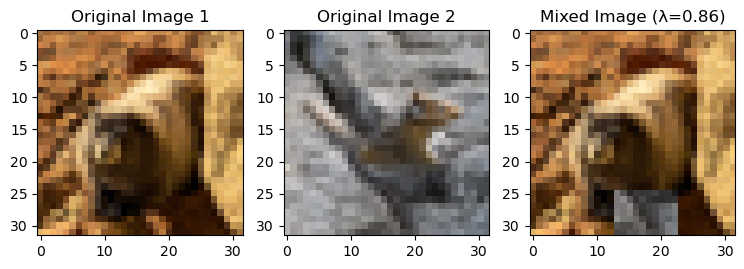

In [5]:
# Imports
import matplotlib.pyplot as plt

# Compare Original Images to Mixed Image
plt.figure(figsize=(9, 3))

### First Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image 1")
plt.imshow(sample_img_png)

### Second Original Image
plt.subplot(1, 3, 2)
plt.title("Original Image 2")
plt.imshow(sample_img_png_2)

### Mixed Image
plt.subplot(1, 3, 3)
plt.title(f"Mixed Image (λ={mixup_lambda:.2f})")
plt.imshow(mixed_img)
plt.show()

Written by Kailey Quesada with the help of generative AI. It appears to have pulled from the following repository: https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py.